# Exercise 5: Simulation of dynamic models of gene expression and regulation (DL 13 October)

Lecturer: Antti Honkela

Your name: Christian Koetsier 

Name of your pair: Bella Zhukova

In this exercise you will implement simulators to simulate biochemical reaction systems similar to ones that could be used to simulate gene expression.

## Task 1: Discrete event simulation I: Simple systems (2 points)

In this task your aim is to perform stochastic simulation of simple discrete reaction systems with a single species X in different scenarios. Each scenario comes with a number of questions. Please answer these by having your code print out the answers.

### a) Simulate the decay of a population of 100 individuals with decay rate 1.

The corresponding reaction system is:
$$ X \rightarrow \emptyset $$

* Implement a function that runs the simulation.
* Repeat the simulation 100 times. What is the average time until extinction? What are the minimum and maximum times?
* What is the mean and standard deviation of the number of individuals left alive after 1 unit of time?
* Plot the simulated numbers of individuals as function of time together in a single plot.

Hints:
* numpy.random (imported as npr) has many useful functions for simulating random variables with specific distributions, e.g. npr.exponential and npr.choice (for subtasks b and c)

N0: 100 | rate: 1 | number of steps: 100 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Time until extinction:
 - max =  9.18963798253
 - min =  3.18785326902
 - average =  5.14504919583 

Number of individuals left alive after 1 unit of time:
 - mean =  35.89
 - standard deviation =  4.83093158718 



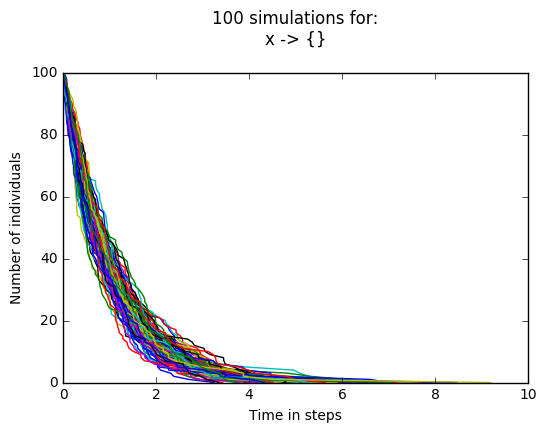

N0: 100 | rate: 0.1 | number of steps: 100 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Time until extinction:
 - max =  89.5381966126
 - min =  30.0432024452
 - average =  54.4233781164 

Number of individuals left alive after 1 unit of time:
 - mean =  89.56
 - standard deviation =  3.05063927727 



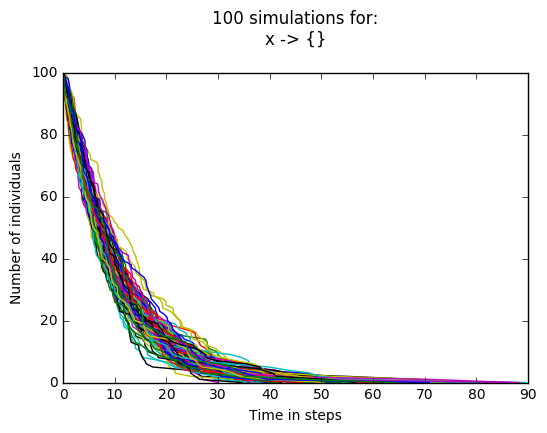

In [1]:
%matplotlib inline
# Import some useful modules
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import math

from scipy.special import comb
import scipy.special as ssp

# Suggested structure: simulate the decay of a population of N0 individuals at rate 'rate' for 'numsteps' steps
def simulate_decay(N0, rate, numsteps):
    # Current population size
    N = N0
    # Current time
    t_cur = 0
    # History of population size across the simulation
    Nhist = np.zeros(numsteps+1)
    Nhist[0] = N
    # Times of the corresponding population sizes
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    # Implementation of the stochastic simulation algorithm (Gillespie 1977, figure 2)
    for i in range(numsteps):
        # Algorithm - Step 1
        h = Nhist[i]
        a = h * rate
        a0 = a   
        # Algorithm - Step 2
        tau = npr.exponential(1/a0)
        # Algorithm - Step 3
        Nhist[i + 1] = Nhist[i] - 1
        Thist[i + 1] = Thist[i] + tau
    return (Thist, Nhist)


# Repeat the simulation
def run_scenario_1a(N0, rate, steps_number, simulationRepeats, showPlot):
    print('N0:', N0, '| rate:', rate, '| number of steps:', steps_number, '| simulation repeats:', simulationRepeats)
    print('----------------------------------------------------------------------------------------------------')
    timeEnds = []
    alive = []
    for i in range(simulationRepeats):
        Thist, Nhist = simulate_decay(N0, rate, steps_number)
        timeEnds.append(Thist[-1])
        alive.append(Nhist[next(index for index,value in enumerate(Thist) if value > 1)])
        if showPlot: plt.plot(Thist, Nhist) 

    # What is the average time until extinction? What are the minimum and maximum times?
    print('Time until extinction:')
    print(' - max = ', np.max(timeEnds))
    print(' - min = ', np.min(timeEnds))
    print(' - average = ', np.mean(timeEnds), '\n')

    # What is the mean and standard deviation of the number of individuals left alive after 1 unit of time?
    print('Number of individuals left alive after 1 unit of time:')
    print(' - mean = ', np.mean(alive))
    print(' - standard deviation = ', np.std(alive), '\n')
    
    if showPlot: 
        # Plot the data
        plt.title(str(simulationRepeats) + ' simulations for:\nx -> {}\n')
        plt.xlabel('Time in steps')
        plt.ylabel('Number of individuals')
        plt.show()
    
# Format: (N0, rate, numsteps, simulationRepeats, showPlot)    
run_scenario_1a(100, 1, 100, 100, True)
# Format: (N0, rate, numsteps, simulationRepeats, showPlot)    
run_scenario_1a(100, 0.1, 100, 100, True)

### b) Simulate a birth-death process of a population of 100 individuals with decay rate 1 and birth rates [0.8, 1, 1.2] for 10000 steps.

The corresponding reaction system is:
\begin{align}
X &\rightarrow 2X \\
X &\rightarrow \emptyset \\
\end{align}

* Implement a function that runs the simulation.
* Repeat each simulation 100 times. How many simulations lead to extinction in each scenario? What are the statistics of the final populations in each scenario (mean, min, max)?


N0: 100 | birth rate: 0.8 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Number of simulations lead to extinction = 100
Final population statistics:
 - mean =  0.0 
 - min =  0.0 
 - max =  0.0 



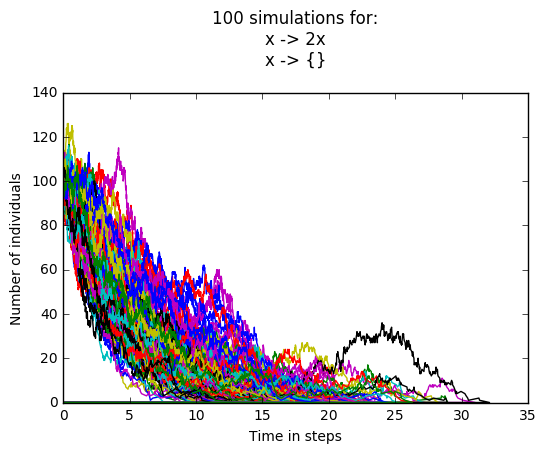

N0: 100 | birth rate: 1.0 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Number of simulations lead to extinction = 31
Final population statistics:
 - mean =  108.2 
 - min =  0.0 
 - max =  432.0 



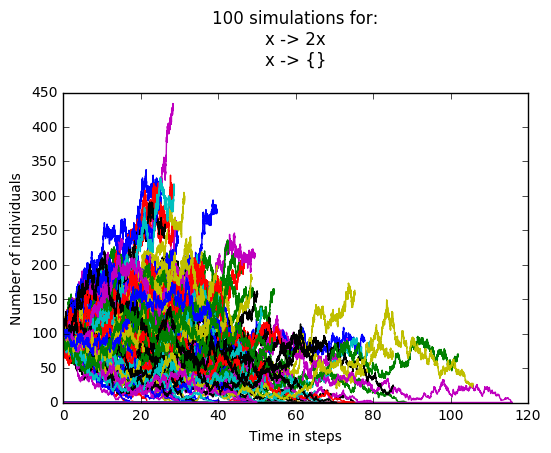

N0: 100 | birth rate: 1.2 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Number of simulations lead to extinction = 0
Final population statistics:
 - mean =  997.54 
 - min =  758.0 
 - max =  1256.0 



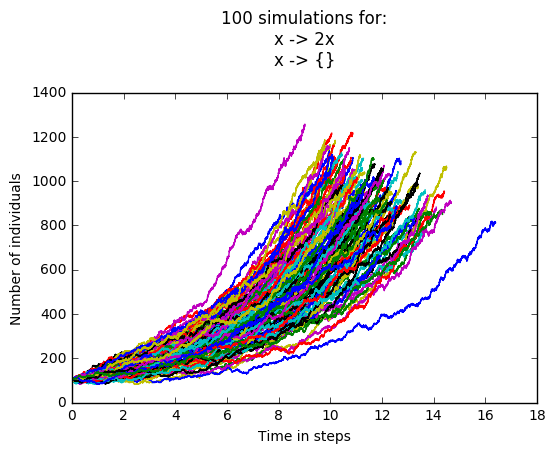

In [2]:
def simulate_birthdeath(N0, birthrate, deathrate, numsteps):
    # Current population size
    N = N0
    # Current time
    t_cur = 0
    # History of population size across the simulation
    Nhist = np.zeros(numsteps+1)
    Nhist[0] = N
    # Times of the corresponding population sizes
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    # Implementation of the stochastic simulation algorithm (Gillespie 1977, figure 2)
    for i in range(numsteps):
        # Algorithm - Step 1
        a1 = N * birthrate
        a2 = N * deathrate
        a0 = a1 + a2
        
        # Stop: no reaction could occur
        if a0 == 0:
            break
        
        # Algorithm - Step 2
        r1, r2 = npr.random(2)
        while r1 == 0:
            r1 = npr.random(1)
        tau = (1/a0) * np.log(1/r1)
        partial_sums = np.cumsum([a1, a2])
        # Which reaction occurred, mu in [0, M-1]
        mu = next(index for index,value in enumerate(partial_sums) if (True if index == 0 else partial_sums[index - 1] < r2 * a0) and r2 * a0 <= partial_sums[index])
            
        # Algorithm - Step 3
        Thist[i + 1] = Thist[i] + tau
        N = N + 1 if mu == 0 else N - 1   # if mu == 0 => birth, if mu == 1 => death
        Nhist[i+1] = N
    return (Thist, Nhist)


# Repeat each simulation 100 times. 
# How many simulations lead to extinction in each scenario? 
# What are the statistics of the final populations in each scenario (mean, min, max)?
def run_scenario_1b(N0, birthrate, deathrate, steps_number, simulationRepeats, showPlot):
    print('N0:', N0, '| birth rate:', birthrate, '| death rate:', deathrate, '| number of steps:', steps_number, '| simulation repeats:', simulationRepeats)
    print('----------------------------------------------------------------------------------------------------')
    alive = []
    for i in range(simulationRepeats):
        Thist, Nhist = simulate_birthdeath(N0, birthrate, deathrate, steps_number)
        alive.append(Nhist[-1])
        if showPlot: plt.plot(Thist, Nhist)
        
    # Population is called "extincted" if final population is of size 0
    print('Number of simulations lead to extinction =', alive.count(0))
    print('Final population statistics:\n - mean = ', np.mean(alive), '\n - min = ', np.min(alive), '\n - max = ', np.max(alive), '\n')
    
    if showPlot:
        # Plot the data
        plt.title(str(simulationRepeats) + ' simulations for:\nx -> 2x\nx -> {}\n')
        plt.xlabel('Time in steps')
        plt.ylabel('Number of individuals')
        plt.show()

# Format: (N0, birthrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1b(100, 0.8, 1.0, 10000, 100, True)
# Format: (N0, birthrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1b(100, 1.0, 1.0, 10000, 100, True)
# Format: (N0, birthrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1b(100, 1.2, 1.0, 10000, 100, True)

### c) Simulate a migration-death process of a population of 100 individuals with decay rate 1 and migration rates [1.0, 10.0, 100.0] for 10000 steps.

The corresponding reaction system is:
\begin{align}
\emptyset &\rightarrow X \\
X &\rightarrow \emptyset \\
\end{align}

* Implement a function that runs the simulation.
* Repeat each simulation 100 times. How many simulations lead to extinction in each scenario? What are the statistics of the final populations in each scenario (mean, min, max)?


N0: 100 | migration rate: 1.0 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Number of simulations lead to extinction = 42
Final population statistics:
 - mean =  1.24 
 - min =  0.0 
 - max =  4.0 



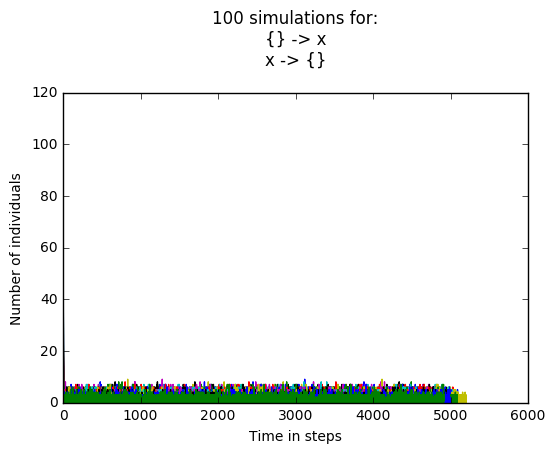

N0: 100 | migration rate: 10.0 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Number of simulations lead to extinction = 0
Final population statistics:
 - mean =  10.82 
 - min =  4.0 
 - max =  18.0 



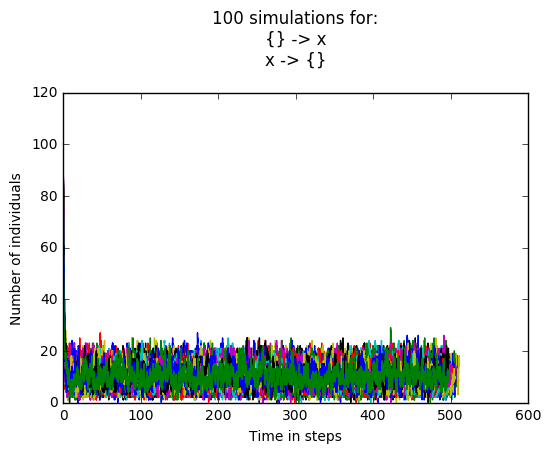

N0: 100 | migration rate: 100.0 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Number of simulations lead to extinction = 0
Final population statistics:
 - mean =  98.98 
 - min =  72.0 
 - max =  124.0 



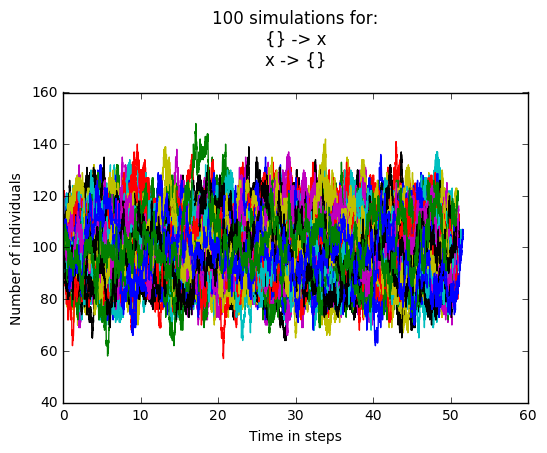

In [18]:
def simulate_migrationdeath(N0, migrationrate, deathrate, numsteps):
    # Current population size
    N = N0
    # Current time
    t_cur = 0
    # History of population size across the simulation
    Nhist = np.zeros(numsteps+1)
    Nhist[0] = N
    # Times of the corresponding population sizes
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    # Implementation of the stochastic simulation algorithm (Gillespie 1977, figure 2)
    for i in range(numsteps):
        # Algorithm - Step 1
        a1 = 1 * migrationrate
        a2 = N * deathrate
        a0 = a1 + a2
                
        # Algorithm - Step 2
        r1, r2 = npr.random(2)
        while r1 == 0:
            r1 = npr.random(1)
        tau = (1/a0) * np.log(1/r1)
        partial_sums = np.cumsum([a1, a2])
        # Which reaction occurred, mu in [0, M-1]
        mu = next(index for index,value in enumerate(partial_sums) if (True if index == 0 else partial_sums[index - 1] < r2 * a0) and r2 * a0 <= partial_sums[index])

        # Algorithm - Step 3
        Thist[i + 1] = Thist[i] + tau   
        N = N + 1 if mu == 0 else N - 1   # if mu == 0 => migration, if mu == 1 => death
        Nhist[i+1] = N
    return (Thist, Nhist)


# Repeat each simulation.
# How many simulations lead to extinction in each scenario? 
# What are the statistics of the final populations in each scenario (mean, min, max)?
def run_scenario_1c(N0, migrationrate, deathrate, steps_number, simulationRepeats, showPlot):
    print('N0:', N0, '| migration rate:', migrationrate, '| death rate:', deathrate, '| number of steps:', steps_number, '| simulation repeats:', simulationRepeats)
    print('----------------------------------------------------------------------------------------------------')
    alive = []
    for i in range(simulationRepeats):
        Thist, Nhist = simulate_migrationdeath(N0, migrationrate, deathrate, steps_number)
        alive.append(Nhist[-1])
        if showPlot: plt.plot(Thist, Nhist)
        
    # Population is called "extincted" if final population is of size 0
    print('Number of simulations lead to extinction =', alive.count(0))
    print('Final population statistics:\n - mean = ', np.mean(alive), '\n - min = ', np.min(alive), '\n - max = ', np.max(alive), '\n')
    
    if showPlot:
        # Plot the data
        plt.title(str(simulationRepeats) + ' simulations for:\n{} -> x\nx -> {}\n')
        plt.xlabel('Time in steps')
        plt.ylabel('Number of individuals')
        plt.show()

# Format: (N0, migrationrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1c(100, 1.0, 1.0, 10000, 100, True)
# Format: (N0, migrationrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1c(100, 10.0, 1.0, 10000, 100, True)
# Format: (N0, migrationrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1c(100, 100.0, 1.0, 10000, 100, True)

Briefly summarise how each model behaves qualitatively in the text area below:

Answer:

- 1a) 
- Based on the given reaction (x->{}) the population is constantly decreasing (dying) as you can see in the graph. The smaler the rate the longer it would take for the population to die (to have a population size equal 0), because it's more unlikely for an individual to die.


- 1b) 
- Based on the given reactions (x->2x|x->{}) the population:
    - decreases: if the birth rate is smaller than the death rate, because its more likely for an individual to die than to 'appear'. The bigger the difference between the rates the faster the population will die.
    - increases: if the birth rate is bigger than the death rate, it's more likely for an individual to 'appear' than to die. The bigger the difference between the rates the faster the population will grow up.
    - if the birth rate is equal to the death rate, it's same likelyhood for an individual to 'appear' as well as to die. So some populations will die, some will grow up. 


- 1c)
- For all three situations that were considered, we can see that overall the graphs look the same. The only difference is in the amplitude. That is because for higher migration rates the possibility for a migration reaction is higher, therefore the whole population would have bigger amount of individuals (more and more would come from 'abroad').



## Task 2: Discrete event simulation II: The general case (3 points)

### a) Implement the general Stochastic Simulation Algorithm of Gillespie (1977).

* Implement a function that runs the simulator.
* Test your simulator by re-implementing exercises 1a and 1b to make sure your results are similar.

In [4]:
# Suggested skeleton for the simulation algorithm
# Suggested arguments are NumPy arrays with sizes as follows:
# inputs: [reactions x state]
# outputs: [reactions x state]
# rates: [reactions]
def stochastic_simulation_algorithm(initstate, inputs, outputs, rates, numsteps):
    # Current time and state
    t_cur = 0
    state = 1.0 * initstate.copy()
    N = len(state)
    M = len(rates)
    # State history
    Nhist = np.zeros((numsteps+1, N))
    Nhist[0,:] = state
    # Time history
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    # Implementation of the stochastic simulation algorithm (Gillespie 1977, figure 2)
    for i in range(numsteps):
        # Algorithm - Step 1
        h = np.ones(M)
        for j in range(M):
            for k in range(N):
                h[j] *= ssp.binom(state[k], inputs[j][k])
        a = h * rates
        a0 = sum(a)
        
        # Stop: no reaction could occur
        if a0 == 0:
            break
            
        # Algorithm - Step 2
        r1, r2 = npr.random(2)
        while r1 == 0:
            r1 = npr.random(1)
        tau = (1/a0) * np.log(1/r1)

        partial_sums = np.cumsum(a)
        # Which reaction occurred, mu in [0, M-1]
        mu = next(index for index,value in enumerate(partial_sums) if (True if index == 0 else partial_sums[index - 1] < r2 * a0) and r2 * a0 <= partial_sums[index])
        
        # Algorithm - Step 3
        Thist[i + 1] = Thist[i] + tau  
        for k in range(N):
            state[k] -= inputs[mu][k]
            state[k] += outputs[mu][k]
        Nhist[i+1,:] = state
    return (Thist, Nhist)

rates: [1] | numsteps: 100
----------------------------------------------------------------------------------------------------


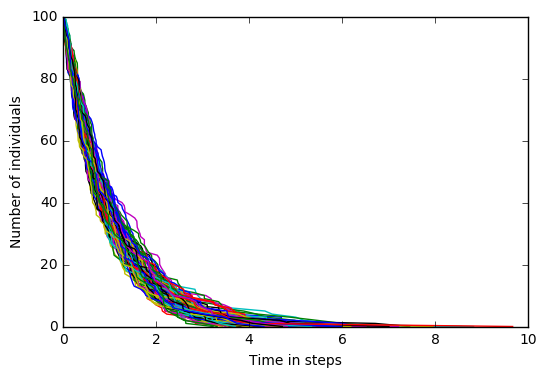

rates: [ 0.8  1. ] | numsteps: 10000
----------------------------------------------------------------------------------------------------


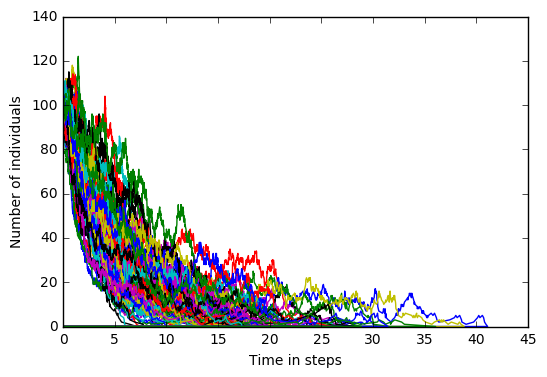

rates: [1 1] | numsteps: 10000
----------------------------------------------------------------------------------------------------


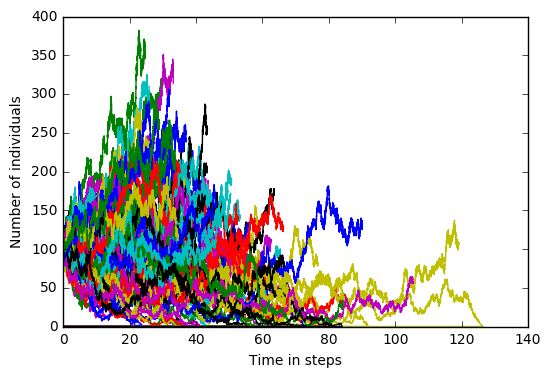

rates: [ 1.2  1. ] | numsteps: 10000
----------------------------------------------------------------------------------------------------


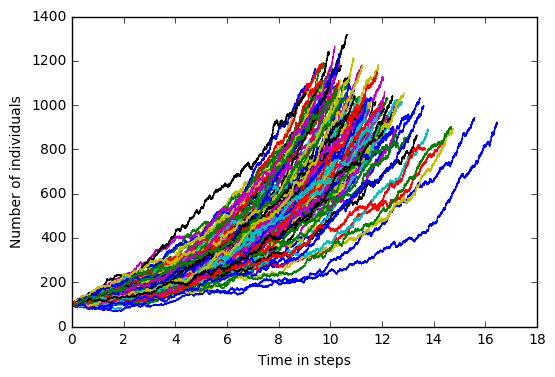

In [23]:
def run_scenario_2a(initstate, inputs, outputs, rates, numsteps, showPlot):
    print('rates:', rates, '| numsteps:', numsteps)
    print('----------------------------------------------------------------------------------------------------')
        
    for i in range(100):
        Thist, Nhist = stochastic_simulation_algorithm(initstate, inputs, outputs, rates, numsteps)
        plt.plot(Thist, Nhist)
    
    plt.xlabel('Time in steps')
    plt.ylabel('Number of individuals')
    plt.show() 

       
# Use the stochastic_simulation_algorithm() function for 1a) 
initstate = np.array([100])
inputs = np.zeros((1,1))
inputs[0][0] = 1
outputs = np.zeros((1,1))
outputs[0][0] = 0
numsteps = 100
rates = np.array([1]) 
# Format: (initstate, inputs, outputs, rates, numsteps, showPlot)    
run_scenario_2a(initstate, inputs, outputs, rates, numsteps, True)      


# Use the stochastic_simulation_algorithm() function for 1b)
initstate = np.array([100])
inputs = np.zeros((2,1))
inputs[0][0] = 1
inputs[1][0] = 1
outputs = np.zeros((2,1))
outputs[0][0] = 2
outputs[1][0] = 0
rates = rates = np.array([0.8,1])
# Format: (initstate, inputs, outputs, rates, numsteps, showPlot)    
run_scenario_2a(initstate, inputs, outputs, rates, 10000, True)  

rates = rates = np.array([1,1])
# Format: (initstate, inputs, outputs, rates, numsteps, showPlot)    
run_scenario_2a(initstate, inputs, outputs, rates, 10000, True)  

rates = rates = np.array([1.2,1])
# Format: (initstate, inputs, outputs, rates, numsteps, showPlot)    
run_scenario_2a(initstate, inputs, outputs, rates, 10000, True)  


### b) Use your simulator to simulate the Lotka-Volterra predator-prey system:
\begin{align}
X_1 + X_2 &\rightarrow 2 X_1 \quad &\text{# Predator-prey interaction} \\
X_2 &\rightarrow 2 X_2 &\text{# Prey reproduction} \\
X_1 &\rightarrow \emptyset &\text{# Predator death} \\
\end{align}

* Try to find rates for the different equations that produce interesting behaviour.
* Plot examples of the behaviour under different rates.

rates: [  0.1  10.   10. ] | numsteps: 10000
----------------------------------------------------------------------------------------------------
Predator population:  69.0
Prey population:  115.0


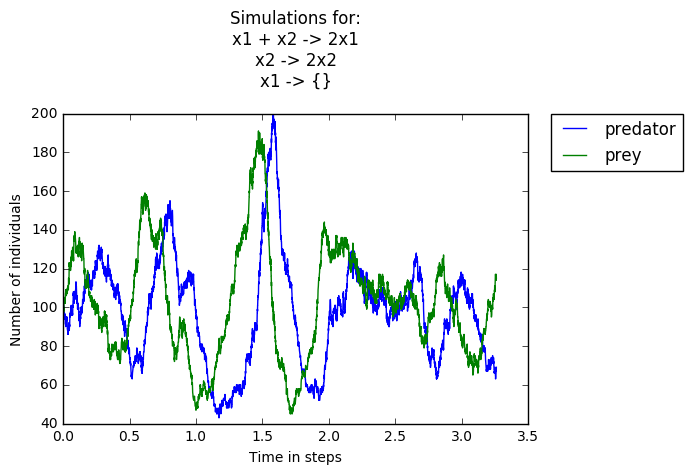

rates: [   0.1  100.     1. ] | numsteps: 10000
----------------------------------------------------------------------------------------------------
Predator population:  2234.0
Prey population:  0.0


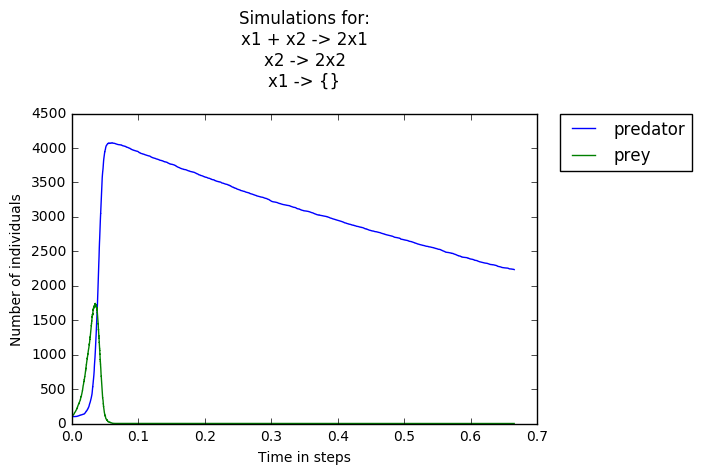

rates: [  0.1   5.   10. ] | numsteps: 10000
----------------------------------------------------------------------------------------------------
Predator population:  0.0
Prey population:  6097.0


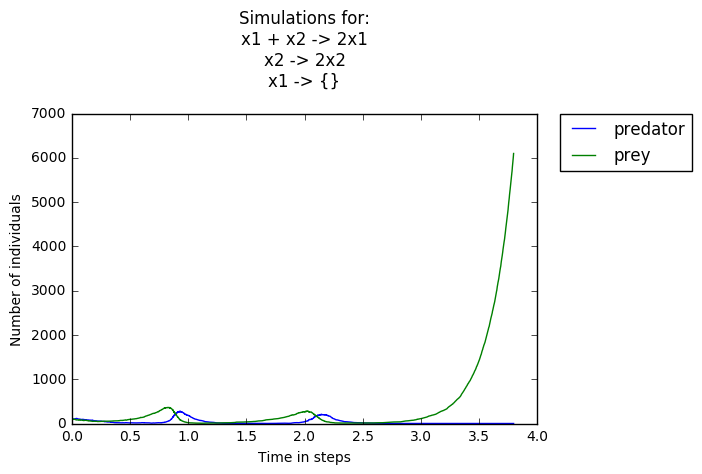

In [5]:
N = 2
M = 3

initstate = np.zeros(N)
initstate[0] = 100 # predator
initstate[1] = 100 # prey

inputs = np.zeros((M, N))
# x1 + x2 ->
inputs[0][0] = 1
inputs[0][1] = 1
# x2 ->
inputs[1][0] = 0
inputs[1][1] = 1
# x1 ->
inputs[2][0] = 1
inputs[2][1] = 0

outputs = np.zeros((M, N))
# -> 2*x1
outputs[0][0] = 2
outputs[0][1] = 0
# -> 2*x2
outputs[1][0] = 0
outputs[1][1] = 2
# -> nothing
outputs[2][0] = 0
outputs[2][1] = 0

numsteps = 10000

def run_scenario_2b(initstate, inputs, outputs, rates, numsteps, showPlot):
    #print('initial state:', initstate, '| inputs:', inputs, '| outputs:', outputs, '| rates:', rates, '| numsteps:', numsteps)
    print('rates:', rates, '| numsteps:', numsteps)
    print('----------------------------------------------------------------------------------------------------')
    
    Thist, Nhist = stochastic_simulation_algorithm(initstate, inputs, outputs, rates, numsteps)
    if showPlot: #plt.plot(Thist, Nhist)
        plt.plot(Thist, [x[0] for x in Nhist], label='predator')
        plt.plot(Thist, [x[1] for x in Nhist], label='prey') 
        
    print('Predator population: ', Nhist[-1][0])
    print('Prey population: ', Nhist[-1][1])

    if showPlot:
        # Plot the data
        plt.title('Simulations for:\nx1 + x2 -> 2x1\nx2 -> 2x2\nx1 -> {}\n')
        plt.xlabel('Time in steps')
        plt.ylabel('Number of individuals')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()      

        
rates = np.array([0.1, 10, 10])         
# Format: (initstate, inputs, outputs, rates, numsteps, showPlot)    
run_scenario_2b(initstate, inputs, outputs, rates, numsteps, True)      
# Result: 
# Pretty much stable situation. Shows that preditors depends on prey population, 
# meaning that their population becomes smaller if prey population is small,
# and their population starts to grow when there is enough prey for them to eat.

rates = np.array([0.1, 100, 1]) 
# Format: (initstate, inputs, outputs, rates, numsteps, showPlot)    
run_scenario_2(initstate, inputs, outputs, rates, numsteps, True)      
# Result:
# Prey die => predators start to die (until extinction)   

rates = np.array([0.1, 5, 10]) 
# Format: (initstate, inputs, outputs, rates, numsteps, showPlot)    
run_scenario_2(initstate, inputs, outputs, rates, numsteps, True)      
# Result:
# After small oscillation, all preditors died therefor prey start to increase its' population 
# (they can produce new individuals without need in 'eating' anyone, so the system is independent and no one 'eats' them).


# What we also tried (no need to rewise)
    #rates = np.array([1, 1, 1]) # predators' steep growth and prey and, therefore, predator populations extinction
    #rates = np.array([0.01, 10, 10]) # wouldn't extinct, with 40 000 steps looks like three next, but slower
    #rates = np.array([0.1, 10, 5]) # beautiful; both populations extinct
    #rates = np.array([0.1, 190, 1]) # equality for this number of steps, but prey populations start to die while predator's — to grow, what will end up as previous run
    #rates = np.array([2, 3000, 1]) 

## Task 3: Continuous-state simulation (3 points)

### a) Implement a deterministic ordinary differential equation simulator using the same input as the stochastic simulator above.

Your simulator should follow Eq. (11) in Gillespie (2000) paper. In order to discretise the time, please select a finite time step \tau and apply the Euler discretisation of approximating
$$ \frac{dX(t)}{dt} = f(X(t)) $$
by
$$ X(t + \tau) \approx X(t) + \tau \cdot f(X(t)). $$

* Repeat exercises 1a, 1b and 2b using your simulator. How do the results differ from the original?

"1a)" initstate:  [100] | rates: [1] | numsteps: 100 | tau: 0.054580000000000004
---------------------------------------------------------------------------------------------------------------


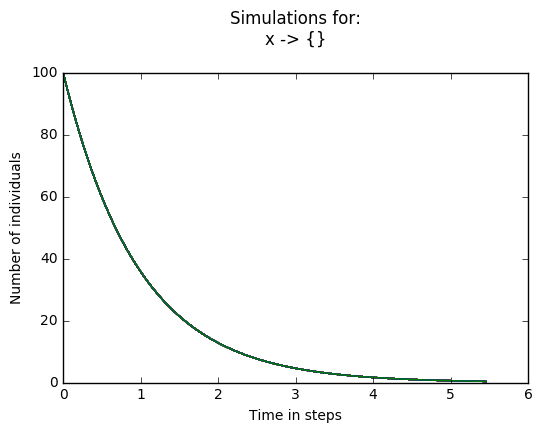

"1b)" initstate:  [100] | rates: [ 0.8  1. ] | numsteps: 100 | tau: 1
---------------------------------------------------------------------------------------------------------------


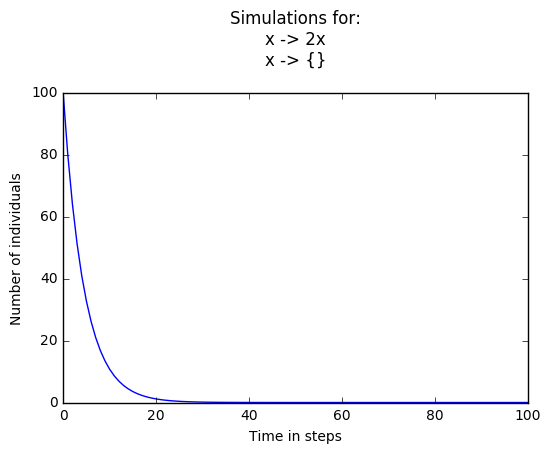

"1b)" initstate:  [100] | rates: [1 1] | numsteps: 100 | tau: 1
---------------------------------------------------------------------------------------------------------------


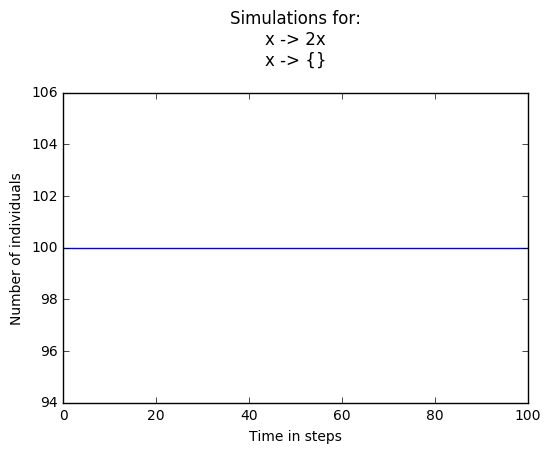

"1b)" initstate:  [100] | rates: [ 1.2  1. ] | numsteps: 100 | tau: 1
---------------------------------------------------------------------------------------------------------------


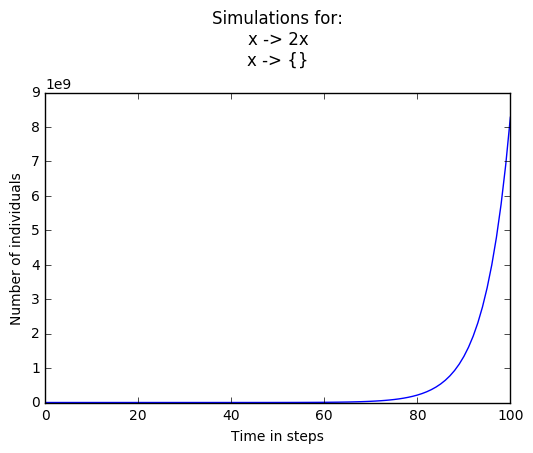

"2)" initstate:  [100 100] | rates: [  0.1  10.   10. ] | numsteps: 10000 | tau: 0.00035
---------------------------------------------------------------------------------------------------------------


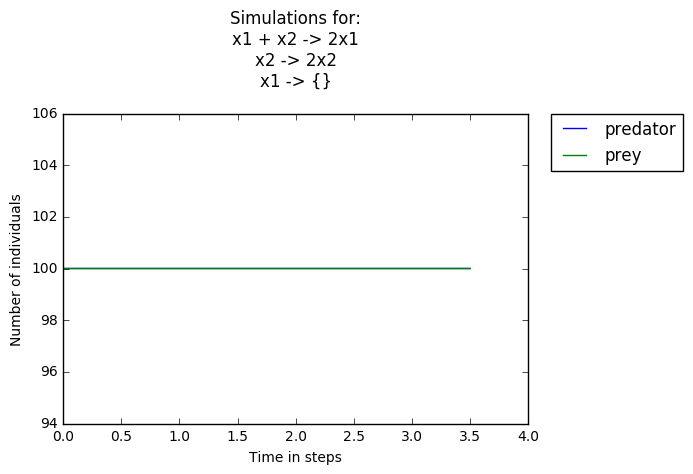

"2)" initstate:  [100 100] | rates: [   0.1  100.     1. ] | numsteps: 10000 | tau: 7e-05
---------------------------------------------------------------------------------------------------------------


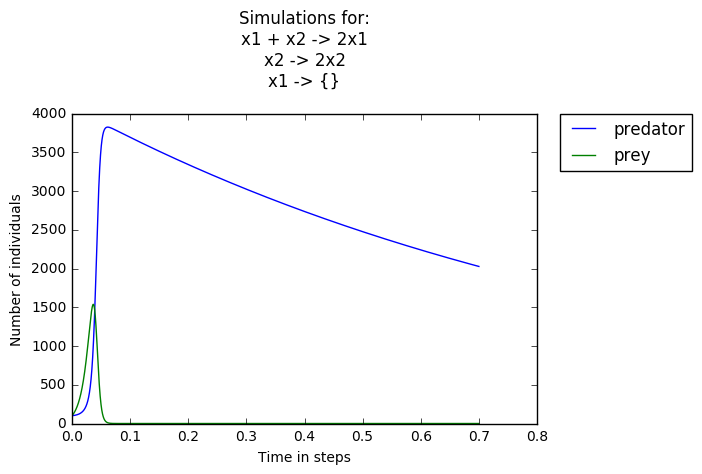

"2)" initstate:  [100 100] | rates: [  0.1   5.   10. ] | numsteps: 10000 | tau: 0.0004
---------------------------------------------------------------------------------------------------------------


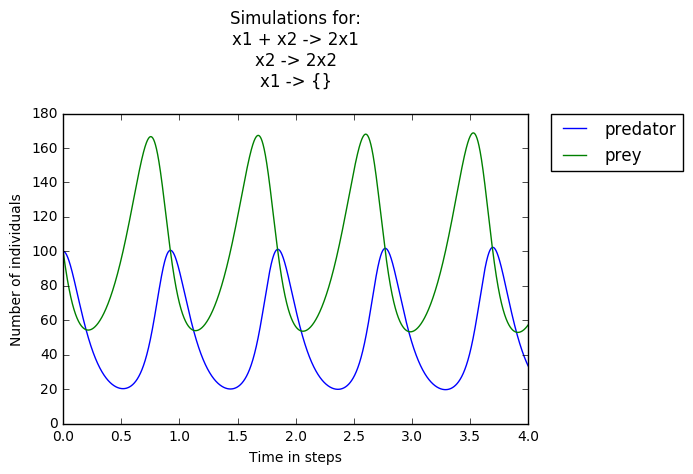

In [27]:
# Suggested skeleton with same arguments as above, except tau is the time step
def simulate_reaction_ode(initstate, inputs, outputs, rates, numsteps, tau):
    # Current time and state
    t_cur = 0
    state = 1.0 * initstate.copy()
    N = len(state)
    M = len(rates)
    # State history
    Nhist = np.zeros((numsteps+1, N))
    Nhist[0,:] = state
    # Time history
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    
    # calculate table v 
    v = np.zeros((M, N))
    for j in range(M):
        for i in range(N):
            v[j][i] = outputs[j][i] - inputs[j][i]
            
    # Implementation of the macroscopic reaction rate equation (Gillespie 2000, equation 11)
    for i in range(numsteps):
        Thist[i+1] = Thist[i] + tau  
        h = np.ones(M)
        for j in range(M):
            for k in range(N):
                if (inputs[j][k] == 1):
                    h[j] *= state[k]
                    #h[j] *= ssp.binom(state[k], inputs[j][k])
                    #h[j] *= comb(state[k], inputs[j][k])
        a = h * rates   # vector with indices [0, .., M-1]
        fx = np.zeros(N)
        for j in range(M):
            for k in range(N):
                fx[k] += v[j][k] * a[j] * tau
    
        state += fx
        Nhist[i+1,:] = state
        
    return (Thist, Nhist)


def simulate_reaction_ode_1a():    
    initstate = np.array([100])
    inputs = np.array([[1]])
    outputs = np.array([[0]])
    rates = np.array([1])
    numsteps = 100
    tau = 5.458/100  # 5.458 — average time from task 1a, therefore we used it here. 

    
    print('"1a)" initstate: ', initstate, '| rates:', rates, '| numsteps:', numsteps, '| tau:', tau)
    print('---------------------------------------------------------------------------------------------------------------')

    for i in range(100):
        Thist, Nhist = simulate_reaction_ode(initstate, inputs, outputs, rates, numsteps, tau)
        plt.plot(Thist, Nhist)
    
    plt.title('Simulations for:\nx -> {}\n')
    plt.xlabel('Time in steps')
    plt.ylabel('Number of individuals')
    plt.show()

# Use the simulate_reaction_ode() function for 1a)
simulate_reaction_ode_1a()
# Comparisons:
# This one, compared to 1a),  is 'stable': every run ends up at the same curve, opposite to 1a)
# (due to determenistic model that is being implemented in this algorithm).
# Each 'time step' what happens is all reactions appear exactly once, and it gives us 'deterministic' situation. 


def simulate_reaction_ode_1b():    
    initstate = np.array([100])
    inputs = np.array([[1],[1]])
    outputs = np.array([[2],[0]])
    rates = np.array([0.8,1])
    numsteps = 100
    tau = 1
    
    print('"1b)" initstate: ', initstate, '| rates:', rates, '| numsteps:', numsteps, '| tau:', tau)
    print('---------------------------------------------------------------------------------------------------------------')
    
    Thist, Nhist = simulate_reaction_ode(initstate, inputs, outputs, rates, numsteps, tau)
    plt.plot(Thist, Nhist)
    plt.title('Simulations for:\nx -> 2x\nx -> {}\n')
    plt.xlabel('Time in steps')
    plt.ylabel('Number of individuals')
    plt.show()
    
    initstate = np.array([100])
    inputs = np.array([[1],[1]])
    outputs = np.array([[2],[0]])
    rates = np.array([1,1])
    numsteps = 100
    tau = 1
    
    print('"1b)" initstate: ', initstate, '| rates:', rates, '| numsteps:', numsteps, '| tau:', tau)
    print('---------------------------------------------------------------------------------------------------------------')
    
    Thist, Nhist = simulate_reaction_ode(initstate, inputs, outputs, rates, numsteps, tau)
    plt.plot(Thist, Nhist)
    plt.title('Simulations for:\nx -> 2x\nx -> {}\n')
    plt.xlabel('Time in steps')
    plt.ylabel('Number of individuals')
    plt.show()

    initstate = np.array([100])
    inputs = np.array([[1],[1]])
    outputs = np.array([[2],[0]])
    rates = np.array([1.2,1])
    numsteps = 100
    tau = 1
    
    print('"1b)" initstate: ', initstate, '| rates:', rates, '| numsteps:', numsteps, '| tau:', tau)
    print('---------------------------------------------------------------------------------------------------------------')
    
    Thist, Nhist = simulate_reaction_ode(initstate, inputs, outputs, rates, numsteps, tau)
    plt.plot(Thist, Nhist)
    plt.title('Simulations for:\nx -> 2x\nx -> {}\n')
    plt.xlabel('Time in steps')
    plt.ylabel('Number of individuals')
    plt.show()

# Use the simulate_reaction_ode() function for 1b)
simulate_reaction_ode_1b()
# Conclusion: 
# 1st simulation: decreasing, since v = [0.8, -1], => fx[]= h*(0.8 - 1) = h * (-0.2) => population would decrease with speed = h*(-0.2)
# 2nd simulation: constant, since v = [1, -1], => fx[] = h*(1 - 1) = h * 0 = 0 => we end up with line (constant number of induviduals)
# 3rd simulation: increasing, since v = [1.2, -1], => fx[] = h*(1.2 - 1) = h * 0.2 => population would increase with speed = h*(0.2)
# How the results differ from the original?
# The same behavior every run, no 'noise'. 


def simulate_reaction_ode_2(rates, tau):    
    initstate = np.array([100, 100])
    inputs = np.array([[1, 1],[0, 1],[1, 0]])
    outputs = np.array([[2,0],[0,2],[0,0]])
    numsteps = 10000
    
    print('"2)" initstate: ', initstate, '| rates:', rates, '| numsteps:', numsteps, '| tau:', tau)
    print('---------------------------------------------------------------------------------------------------------------')
    
    Thist, Nhist = simulate_reaction_ode(initstate, inputs, outputs, rates, numsteps, tau)
    plt.plot(Thist, [x[0] for x in Nhist], label='predator')
    plt.plot(Thist, [x[1] for x in Nhist], label='prey') 
    plt.title('Simulations for:\nx1 + x2 -> 2x1\nx2 -> 2x2\nx1 -> {}\n')
    plt.xlabel('Time in steps')
    plt.ylabel('Number of individuals')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
# Use the simulate_reaction_ode() function for 1b)
simulate_reaction_ode_2(np.array([0.1,10,10]), 3.5/10000)
simulate_reaction_ode_2(np.array([0.1,100,1]), 0.7/10000)
simulate_reaction_ode_2(np.array([0.1,5,10]), 4/10000)
# Founds:
# In case with rates=[0.1,10,10] (fx = [0,0]) will be constant
# How the results differ from the original?
# First graph is just constant, since all elements in 'a[]' (array of h*rates) would be equal (due to rates that we chose),
# while 'v[]' gives us such difference that fx[] would be just zeros (therefore no change in individuals number).
# Second graph looks the same, meaning that with these rates it doesn't really matters if we use one reaction or both at each 'time step'.
# Third graph hugely differs from the "stachastic" one, since there preditors extinct, and here they are not 
# (just oscilating under number of prey, being dependent on it)

### b) Implement a stochastic continuous-state simulator using the same input as above.

Your simulator should follow Eq. (21) of the Gillespie (2000) paper.

* Repeat exercises 1a, 1b and 2b using your simulator. How do the results differ from the original and from 3a?

"1a)" initstate:  [100] | rates: [1] | numsteps: 100 | tau: 0.054580000000000004
---------------------------------------------------------------------------------------------------------------


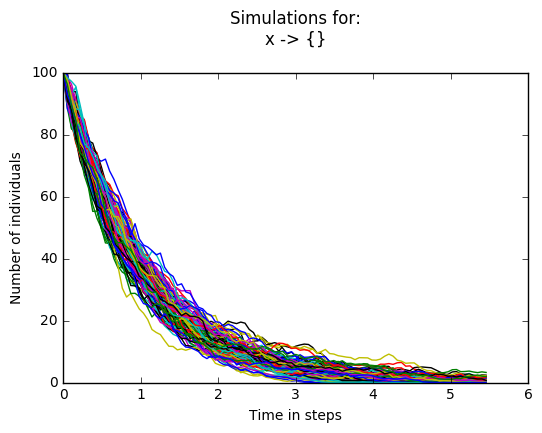

"1b)" initstate:  [100] | rates: [ 0.8  1. ] | numsteps: 100 | tau: 0.054580000000000004
---------------------------------------------------------------------------------------------------------------


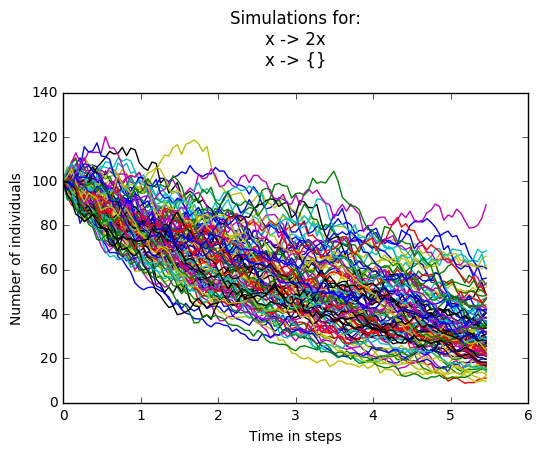

"1b)" initstate:  [100] | rates: [1 1] | numsteps: 100 | tau: 0.1
---------------------------------------------------------------------------------------------------------------


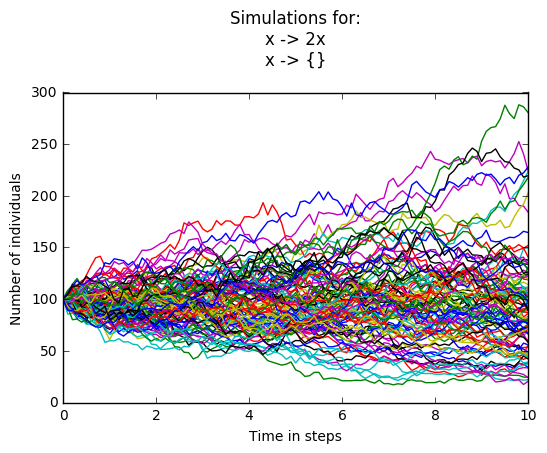

"1b)" initstate:  [100] | rates: [ 1.2  1. ] | numsteps: 100 | tau: 0.1
---------------------------------------------------------------------------------------------------------------


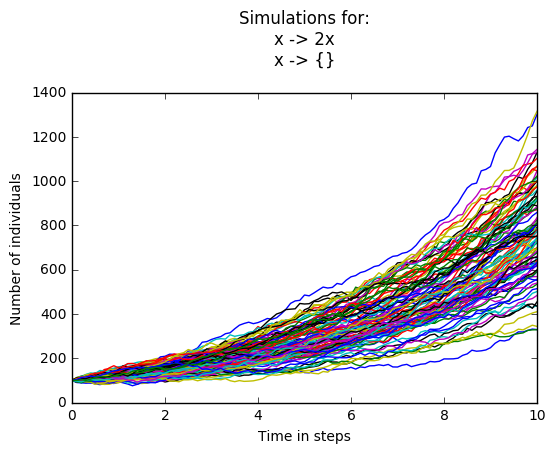

"2)" initstate:  [100 100] | rates: [  0.1  10.   10. ] | numsteps: 10000 | tau: 0.00035
---------------------------------------------------------------------------------------------------------------


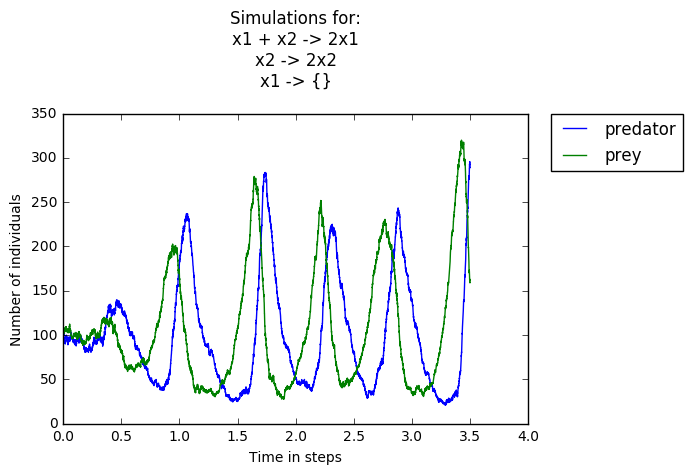

"2)" initstate:  [100 100] | rates: [   0.1  100.     1. ] | numsteps: 10000 | tau: 7e-05
---------------------------------------------------------------------------------------------------------------


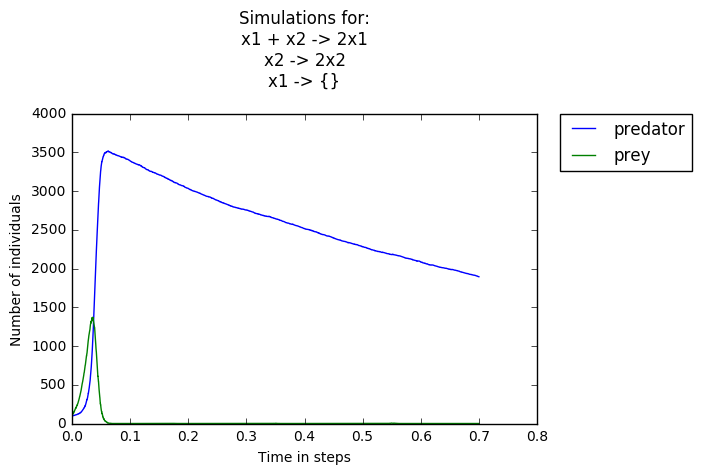

"2)" initstate:  [100 100] | rates: [  0.1   5.   10. ] | numsteps: 10000 | tau: 0.0004
---------------------------------------------------------------------------------------------------------------


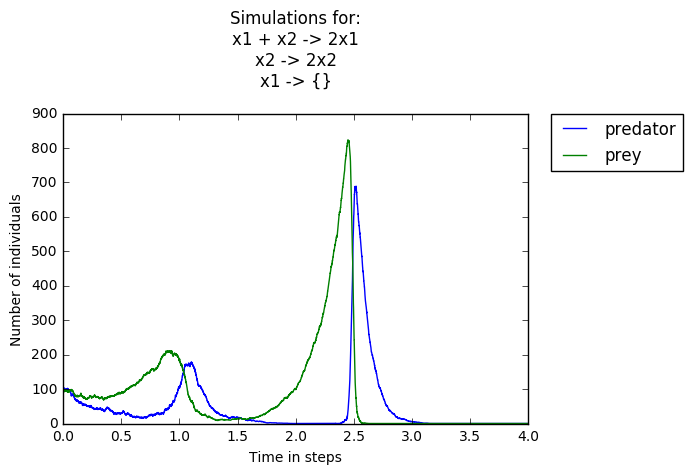

In [40]:
# Suggested skeleton with same arguments as above, except tau is the time step
def simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, numsteps, tau):
    # Current time and state
    t_cur = 0
    state = 1.0 * initstate.copy()
    N = len(state)
    M = len(rates)
    # State history
    Nhist = np.zeros((numsteps+1, N))
    Nhist[0,:] = state
    # Time history
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    v = np.zeros((M, N))
    for j in range(M):
        for i in range(N):
            v[j][i] = outputs[j][i] - inputs[j][i]
    # Implementation of the equation: (Gillespie 2000, equation 21)
    for i in range(numsteps):
        Thist[i+1] = Thist[i] + tau  
        h = np.ones(M)
        for j in range(M):
            for k in range(N):
                if (inputs[j][k] == 1):
                    h[j] *= state[k]
                    #h[j] *= ssp.binom(state[k], inputs[j][k])
                    #h[j] *= comb(state[k], inputs[j][k])
        a = h * rates   # vector with indices [0, .., M-1]
        fx = np.zeros(N)
        gx = np.zeros(N)
        for j in range(M):
            for k in range(N):
                fx[k] += v[j][k] * a[j] * tau
                gx[k] += v[j][k] * np.sqrt(a[j] * tau) * npr.normal(0,1)
#                 gx[k] += v[j][k] * np.sqrt(a[j] * tau) * npr.random(1)

        state += fx + gx
        for k in range(N):
            if state[k] < 1e-6:
                state[k] = 1e-6
        Nhist[i+1,:] = state
    return (Thist, Nhist)


def simulate_chemical_langevin_eq_1a():    
    initstate = np.array([100])
    inputs = np.array([[1]])
    outputs = np.array([[0]])
    rates = np.array([1])
    numsteps = 100
    tau = 5.458/100
    
    print('"1a)" initstate: ', initstate, '| rates:', rates, '| numsteps:', numsteps, '| tau:', tau)
    print('---------------------------------------------------------------------------------------------------------------')

    for i in range(100):
        Thist, Nhist = simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, numsteps, tau)
        plt.plot(Thist, Nhist)
    
    plt.title('Simulations for:\nx -> {}\n')
    plt.xlabel('Time in steps')
    plt.ylabel('Number of individuals')
    plt.show()

# Use the simulate_chemical_langevin_eq() function for 1a)
simulate_chemical_langevin_eq_1a()
# How do the results differ from the original and from 3a?
# No significant difference from the original since this case is stochastic (as the original).
# And comparison with 3a is the same as 1a to 3a.


def simulate_chemical_langevin_eq_1b():    
    initstate = np.array([100])
    inputs = np.array([[1],[1]])
    outputs = np.array([[2],[0]])
    rates = np.array([0.8,1])
    numsteps = 100
    tau = 5.458/100
    
    print('"1b)" initstate: ', initstate, '| rates:', rates, '| numsteps:', numsteps, '| tau:', tau)
    print('---------------------------------------------------------------------------------------------------------------')

    for i in range(100):
        Thist, Nhist = simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, numsteps, tau)
        plt.plot(Thist, Nhist)    
    plt.title('Simulations for:\nx -> 2x\nx -> {}\n')
    plt.xlabel('Time in steps')
    plt.ylabel('Number of individuals')
    plt.show()
    
    initstate = np.array([100])
    inputs = np.array([[1],[1]])
    outputs = np.array([[2],[0]])
    rates = np.array([1,1])
    numsteps = 100
    tau = 0.1
    
    print('"1b)" initstate: ', initstate, '| rates:', rates, '| numsteps:', numsteps, '| tau:', tau)
    print('---------------------------------------------------------------------------------------------------------------')

    for i in range(100):
        Thist, Nhist = simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, numsteps, tau)
        plt.plot(Thist, Nhist)    
    plt.title('Simulations for:\nx -> 2x\nx -> {}\n')
    plt.xlabel('Time in steps')
    plt.ylabel('Number of individuals')
    plt.show()
    
    initstate = np.array([100])
    inputs = np.array([[1],[1]])
    outputs = np.array([[2],[0]])
    rates = np.array([1.2,1])
    numsteps = 100
    tau = 0.1
    
    print('"1b)" initstate: ', initstate, '| rates:', rates, '| numsteps:', numsteps, '| tau:', tau)
    print('---------------------------------------------------------------------------------------------------------------')

    for i in range(100):
        Thist, Nhist = simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, numsteps, tau)
        plt.plot(Thist, Nhist)    
    plt.title('Simulations for:\nx -> 2x\nx -> {}\n')
    plt.xlabel('Time in steps')
    plt.ylabel('Number of individuals')
    plt.show()

# Use the simulate_chemical_langevin_eq() function for 1b)
simulate_chemical_langevin_eq_1b()
# How do the results differ from the original and from 3a?
# No significant difference from the original since this case is stochastic (as the original).
# And comparison with 3a is the same as 1b to 3a.

def simulate_chemical_langevin_eq_2(rates, tau):    
    initstate = np.array([100, 100])
    inputs = np.array([[1, 1],[0,1],[1,0]])
    outputs = np.array([[2,0],[0,2],[0,0]])
    numsteps = 10000
    
    print('"2)" initstate: ', initstate, '| rates:', rates, '| numsteps:', numsteps, '| tau:', tau)
    print('---------------------------------------------------------------------------------------------------------------')

    Thist, Nhist = simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, numsteps, tau)
    plt.plot(Thist, [x[0] for x in Nhist], label='predator')
    plt.plot(Thist, [x[1] for x in Nhist], label='prey') 
    plt.title('Simulations for:\nx1 + x2 -> 2x1\nx2 -> 2x2\nx1 -> {}\n')
    plt.xlabel('Time in steps')
    plt.ylabel('Number of individuals')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

# Use the simulate_chemical_langevin_eq() function for 2)
simulate_chemical_langevin_eq_2(np.array([0.1,10,10]), 3.5/10000)
simulate_chemical_langevin_eq_2(np.array([0.1,100,1]), 0.7/10000)
simulate_chemical_langevin_eq_2(np.array([0.1,5,10]), 4/10000)
# How do the results differ from the original and from 3a?
# No significant difference from the original since this case is stochastic (as the original).
# And comparison with 3a is the same as 2 to 3a.

## Task 4: Simulating a system of repression of expression (2 points)

In this task you will implement a simplified model of repressive regulation, a simplified "repressilator". This is more complicated than the predator-prey system in 2b because preventing preduction is not the same as enhancing degradation. (In the predator analogue, predators would only target the young and therefore decrease the birth rate of prey but leave the existing (adult) population intact.

The repressilator model has 3 genes, each of which represses the next in a cycle A -> B -> C -> A. A realistic model would include 6 species to model both mRNAs and protein levels of each gene. In this task we simplify things a bit by combining the mRNA and protein for each gene.

In order to simulate repression, we augment the model by introducing additional states $aX$ and $rX$ that represent "active" and "repressed" promoter states of gene $X \in \{A, B, C\}$. Production of gene $X$ only happens when the promoter is in the active state and the repressor moves the promoter into repressed state. The system can be expressed through reactions:
\begin{align}
aX &\rightarrow aX + 10 X \quad &\text{# transcription} \\
Y + aX &\rightarrow rX &\text{# repression, } Y \text{ is the repressor}\\
rX &\rightarrow aX &\text{# recovery from repression} \\
X &\rightarrow \emptyset &\text{# decay}
\end{align}
These reactions are repeated for all genes, resulting in total 12 reactions for the 9 species in the system.

* Implement the reactions and simulate them using the simulators you implemented in Tasks 2 and/or 3. Use rate 0.1 for the decay equation and rate 1.0 for the others.
* Remember that aX and rX represent different states of the single promoter of a gene, there are not supposed to be many copies of them.
* Repeat the stochastic simulations 100 times and compute the average. Visualise the gene counts from a number of the individual simulations.

     X    aX    rX
A:  [ 32.   0.   1.]
B:  [ 0.  0.  1.]
C:  [ 24.   1.   0.]


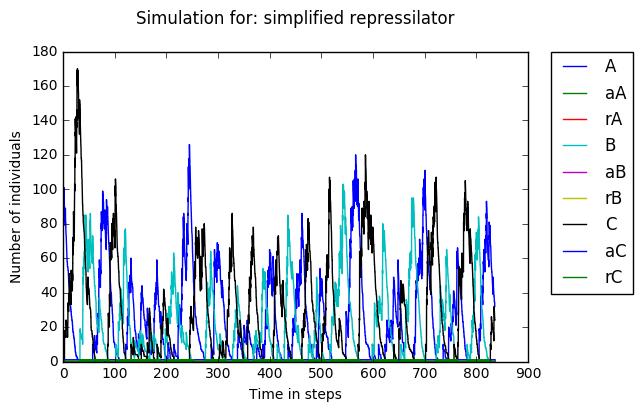

     X    aX    rX
A:  [ 0.  1.  0.]
B:  [ 14.   1.   0.]
C:  [ 47.   0.   1.]


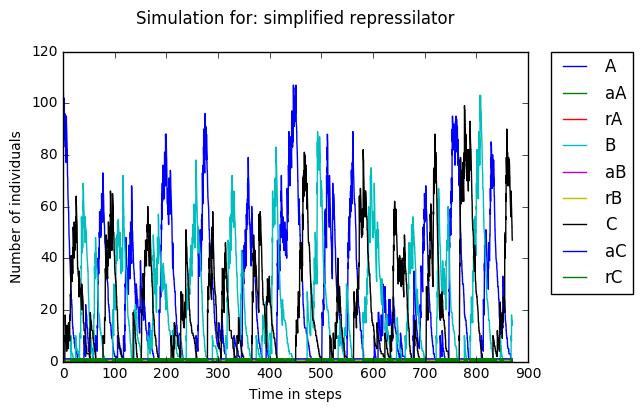

     X    aX    rX
A:  [ 76.   0.   1.]
B:  [ 0.  0.  1.]
C:  [ 19.   0.   1.]


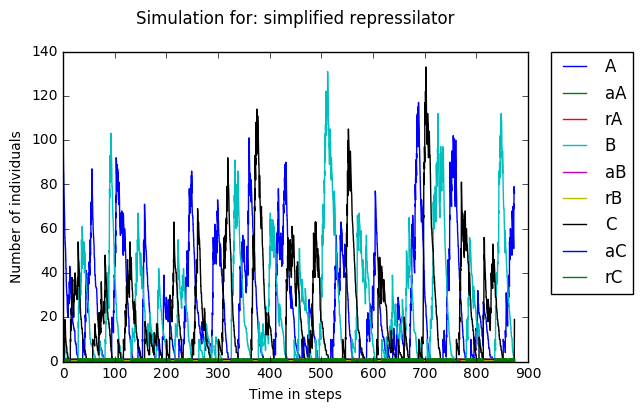

     X    aX    rX
A:  [ 0.  0.  1.]
B:  [ 20.   1.   0.]
C:  [ 44.   0.   1.]


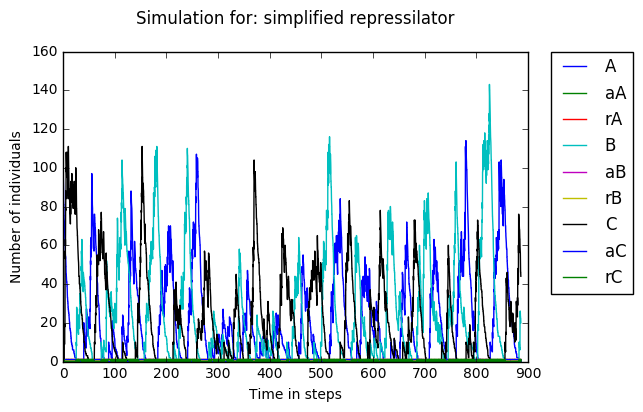

     X    aX    rX
A:  [ 56.   1.   0.]
B:  [ 5.  0.  1.]
C:  [ 0.  0.  1.]


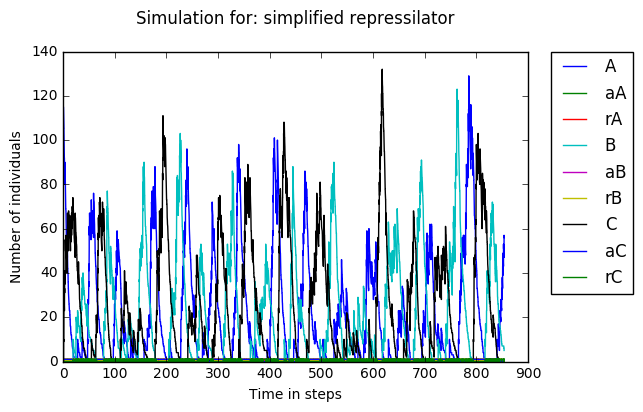

Average for A:  21.36
Average for aA:  0.32
Average for rA:  0.68

Average for B:  25.4
Average for aB:  0.43
Average for rB:  0.57

Average for C:  24.22
Average for aC:  0.33
Average for rC:  0.67


In [44]:
# N = 9
# M = 12

# from Task2
final = []
for i in range(100):
    # A,aA,rA, B,aB,rB, C,aC,rC
    initstate = np.array([100,0,1, 0,0,1, 0,0,1])

    inputs = np.array([
            [0,1,0, 0,0,0, 0,0,0],
            [0,1,0, 0,0,0, 1,0,0],
            [0,0,1, 0,0,0, 0,0,0],
            [1,0,0, 0,0,0, 0,0,0],

            [0,0,0, 0,1,0, 0,0,0],
            [1,0,0, 0,1,0, 0,0,0],
            [0,0,0, 0,0,1, 0,0,0],
            [0,0,0, 1,0,0, 0,0,0],

            [0,0,0, 0,0,0, 0,1,0],
            [0,0,0, 1,0,0, 0,1,0],
            [0,0,0, 0,0,0, 0,0,1],
            [0,0,0, 0,0,0, 1,0,0]
        ]);

    outputs = np.array([
            [10,1,0, 0,0,0, 0,0,0],
            [ 0,0,1, 0,0,0, 0,0,0],
            [ 0,1,0, 0,0,0, 0,0,0],
            [ 0,0,0, 0,0,0, 0,0,0],

            [0,0,0, 10,1,0, 0,0,0],
            [0,0,0,  0,0,1, 0,0,0],
            [0,0,0,  0,1,0, 0,0,0],
            [0,0,0,  0,0,0, 0,0,0],

            [0,0,0, 0,0,0, 10,1,0],
            [0,0,0, 0,0,0,  0,0,1],
            [0,0,0, 0,0,0,  0,1,0],
            [0,0,0, 0,0,0,  0,0,0]
        ]);

    rates = np.array([1,1,1,0.1, 1,1,1,0.1, 1,1,1,0.1])

    numsteps = 10000

    Thist, Nhist = stochastic_simulation_algorithm(initstate, inputs, outputs, rates, numsteps)
    final.append(Nhist[-1])
    if i%20 == 0:
        print('     X    aX    rX')
        print('A: ', Nhist[-1][0:3])
        print('B: ', Nhist[-1][3:6])
        print('C: ', Nhist[-1][6:9])
        
        plt.plot(Thist, [x[0] for x in Nhist], label='A')
        plt.plot(Thist, [x[1] for x in Nhist], label='aA') 
        plt.plot(Thist, [x[2] for x in Nhist], label='rA') 
        plt.plot(Thist, [x[3] for x in Nhist], label='B') 
        plt.plot(Thist, [x[4] for x in Nhist], label='aB') 
        plt.plot(Thist, [x[5] for x in Nhist], label='rB') 
        plt.plot(Thist, [x[6] for x in Nhist], label='C') 
        plt.plot(Thist, [x[7] for x in Nhist], label='aC') 
        plt.plot(Thist, [x[8] for x in Nhist], label='rC') 
        plt.title('Simulation for: simplified repressilator\n')
        plt.xlabel('Time in steps')
        plt.ylabel('Number of individuals')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        plt.show()

print('Average for A: ', np.mean([x[0] for x in final]))
print('Average for aA: ', np.mean([x[1] for x in final]))
print('Average for rA: ', np.mean([x[2] for x in final]))

print('\nAverage for B: ', np.mean([x[3] for x in final]))
print('Average for aB: ', np.mean([x[4] for x in final]))
print('Average for rB: ', np.mean([x[5] for x in final]))

print('\nAverage for C: ', np.mean([x[6] for x in final]))
print('Average for aC: ', np.mean([x[7] for x in final]))
print('Average for rC: ', np.mean([x[8] for x in final]))

     X    aX    rX
A:  [ 21.64871089   0.29210046   0.70789954]
B:  [ 5.57114547  0.04413692  0.95586308]
C:  [ 2.56021306  0.1489892   0.8510108 ]


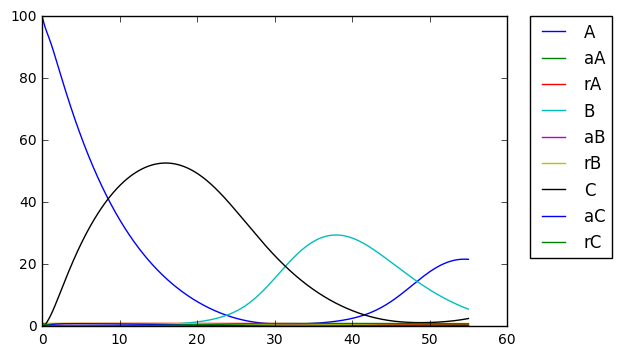

In [57]:
# from Task3a (deterministic)

# A,aA,rA, B,aB,rB, C,aC,rC
initstate = np.array([100,0,1, 0,0,1, 0,0,1])

inputs = np.array([
        [0,1,0, 0,0,0, 0,0,0],
        [0,1,0, 0,0,0, 1,0,0],
        [0,0,1, 0,0,0, 0,0,0],
        [1,0,0, 0,0,0, 0,0,0],

        [0,0,0, 0,1,0, 0,0,0],
        [1,0,0, 0,1,0, 0,0,0],
        [0,0,0, 0,0,1, 0,0,0],
        [0,0,0, 1,0,0, 0,0,0],

        [0,0,0, 0,0,0, 0,1,0],
        [0,0,0, 1,0,0, 0,1,0],
        [0,0,0, 0,0,0, 0,0,1],
        [0,0,0, 0,0,0, 1,0,0]
    ]);

outputs = np.array([
        [10,1,0, 0,0,0, 0,0,0],
        [ 0,0,1, 0,0,0, 0,0,0],
        [ 0,1,0, 0,0,0, 0,0,0],
        [ 0,0,0, 0,0,0, 0,0,0],

        [0,0,0, 10,1,0, 0,0,0],
        [0,0,0,  0,0,1, 0,0,0],
        [0,0,0,  0,1,0, 0,0,0],
        [0,0,0,  0,0,0, 0,0,0],

        [0,0,0, 0,0,0, 10,1,0],
        [0,0,0, 0,0,0,  0,0,1],
        [0,0,0, 0,0,0,  0,1,0],
        [0,0,0, 0,0,0,  0,0,0]
    ]);

rates = np.array([1,1,1,0.1, 1,1,1,0.1, 1,1,1,0.1])

numsteps = 10000

Thist, Nhist = simulate_reaction_ode(initstate, inputs, outputs, rates, numsteps, 55/numsteps)

print('     X    aX    rX')
print('A: ', Nhist[-1][0:3])
print('B: ', Nhist[-1][3:6])
print('C: ', Nhist[-1][6:9])
plt.plot(Thist, [x[0] for x in Nhist], label='A')
plt.plot(Thist, [x[1] for x in Nhist], label='aA')
plt.plot(Thist, [x[2] for x in Nhist], label='rA')
plt.plot(Thist, [x[3] for x in Nhist], label='B')
plt.plot(Thist, [x[4] for x in Nhist], label='aB')
plt.plot(Thist, [x[5] for x in Nhist], label='rB')
plt.plot(Thist, [x[6] for x in Nhist], label='C')
plt.plot(Thist, [x[7] for x in Nhist], label='aC')
plt.plot(Thist, [x[8] for x in Nhist], label='rC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


The results here are awful, but You said that we should leave it like that, since no one knows where the bug is

     X    aX    rX
A:  [  1.00000000e-06   8.79369082e+02   4.75373001e+03]
B:  [    84.05503663    723.3743611   17727.97365761]
C:  [   30.64437217   465.64999706  6194.30465333]


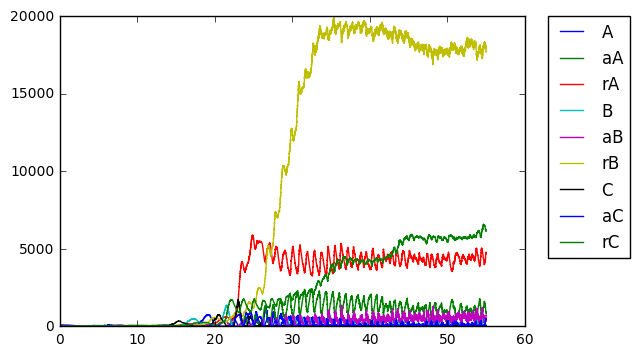

Average for A:  1e-06
Average for aA:  879.369081548
Average for rA:  4753.73001168

Average for B:  84.0550366323
Average for aB:  723.374361098
Average for rB:  17727.9736576

Average for C:  30.6443721705
Average for aC:  465.649997059
Average for rC:  6194.30465333

The results here are awful, but You said that we should leave it like that, since no one knows where the bug is


In [61]:
# from Task3b (stochastic)
final = []
for i in range(1):
    # A,aA,rA, B,aB,rB, C,aC,rC
    initstate = np.array([100,0,1, 0,0,1, 0,0,1])

    inputs = np.array([
            [0,1,0, 0,0,0, 0,0,0],
            [0,1,0, 0,0,0, 1,0,0],
            [0,0,1, 0,0,0, 0,0,0],
            [1,0,0, 0,0,0, 0,0,0],

            [0,0,0, 0,1,0, 0,0,0],
            [1,0,0, 0,1,0, 0,0,0],
            [0,0,0, 0,0,1, 0,0,0],
            [0,0,0, 1,0,0, 0,0,0],

            [0,0,0, 0,0,0, 0,1,0],
            [0,0,0, 1,0,0, 0,1,0],
            [0,0,0, 0,0,0, 0,0,1],
            [0,0,0, 0,0,0, 1,0,0]
        ]);

    outputs = np.array([
            [10,1,0, 0,0,0, 0,0,0],
            [ 0,0,1, 0,0,0, 0,0,0],
            [ 0,1,0, 0,0,0, 0,0,0],
            [ 0,0,0, 0,0,0, 0,0,0],

            [0,0,0, 10,1,0, 0,0,0],
            [0,0,0,  0,0,1, 0,0,0],
            [0,0,0,  0,1,0, 0,0,0],
            [0,0,0,  0,0,0, 0,0,0],

            [0,0,0, 0,0,0, 10,1,0],
            [0,0,0, 0,0,0,  0,0,1],
            [0,0,0, 0,0,0,  0,1,0],
            [0,0,0, 0,0,0,  0,0,0]
        ]);

    rates = np.array([1,1,1,0.1, 1,1,1,0.1, 1,1,1,0.1])

    numsteps = 10000
    
    Thist, Nhist = simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, numsteps, 55/numsteps)
    final.append(Nhist[-1])
    if i%20 == 0:
        print('The results here are awful, but You said that we should leave it like that, since no one knows where the bug is\n')
        print('     X    aX    rX')
        print('A: ', Nhist[-1][0:3])
        print('B: ', Nhist[-1][3:6])
        print('C: ', Nhist[-1][6:9])
        plt.plot(Thist, [x[0] for x in Nhist], label='A')
        plt.plot(Thist, [x[1] for x in Nhist], label='aA')
        plt.plot(Thist, [x[2] for x in Nhist], label='rA')
        plt.plot(Thist, [x[3] for x in Nhist], label='B')
        plt.plot(Thist, [x[4] for x in Nhist], label='aB')
        plt.plot(Thist, [x[5] for x in Nhist], label='rB')
        plt.plot(Thist, [x[6] for x in Nhist], label='C')
        plt.plot(Thist, [x[7] for x in Nhist], label='aC')
        plt.plot(Thist, [x[8] for x in Nhist], label='rC')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

print('Average for A: ', np.mean([x[0] for x in final]))
print('Average for aA: ', np.mean([x[1] for x in final]))
print('Average for rA: ', np.mean([x[2] for x in final]))

print('\nAverage for B: ', np.mean([x[3] for x in final]))
print('Average for aB: ', np.mean([x[4] for x in final]))
print('Average for rB: ', np.mean([x[5] for x in final]))

print('\nAverage for C: ', np.mean([x[6] for x in final]))
print('Average for aC: ', np.mean([x[7] for x in final]))
print('Average for rC: ', np.mean([x[8] for x in final]))

print('\nThe results here are awful, but You said that we should leave it like that, since no one knows where the bug is')

Bonus task: implement a full repressilator model including both mRNAs and proteins. Try to assign realistic rates for all the reactions. Simulate your model using the simulators you implemented in Tasks 2 and/or 3 and visualise the results.

\begin{align}
aX &\rightarrow aX + 10 mX \quad &\text{# mX — mRNA } \\
mX &\rightarrow \emptyset &\text{# decay of mRNA} \\
mX &\rightarrow X &\text{# producing protein} \\
Y + aX &\rightarrow rX &\text{# repression, } Y \text{ is the repressor}\\
rX &\rightarrow aX &\text{# recovery from repression} \\
X &\rightarrow \emptyset &\text{# decay}
\end{align}

     X    aX    rX    mX
A:  [ 15.   1.   0.   6.]
B:  [ 21.   0.   1.   0.]
C:  [ 0.  0.  1.  0.]


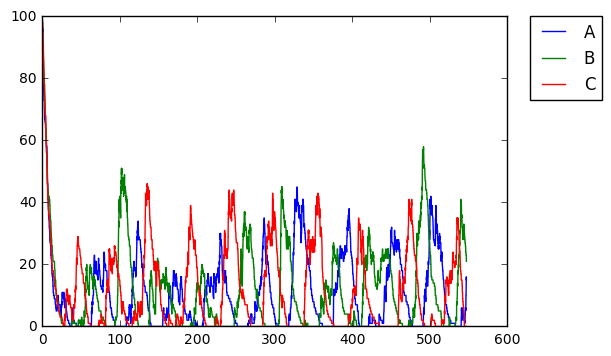

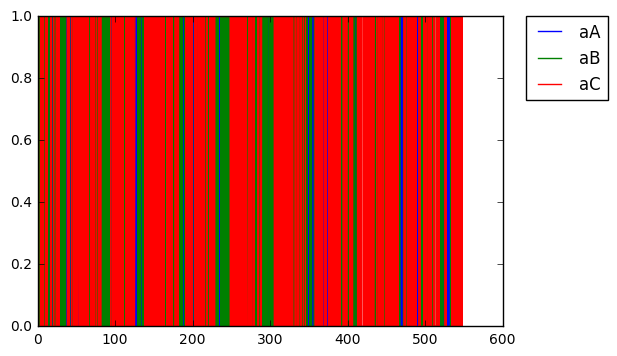

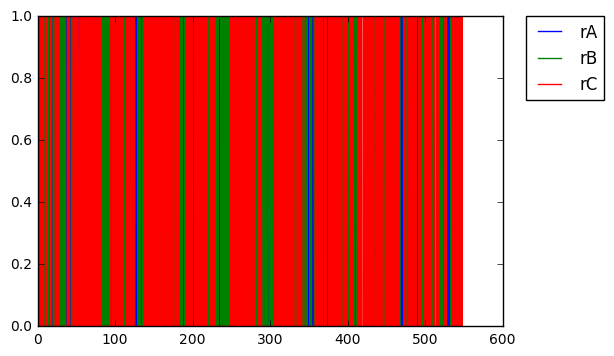

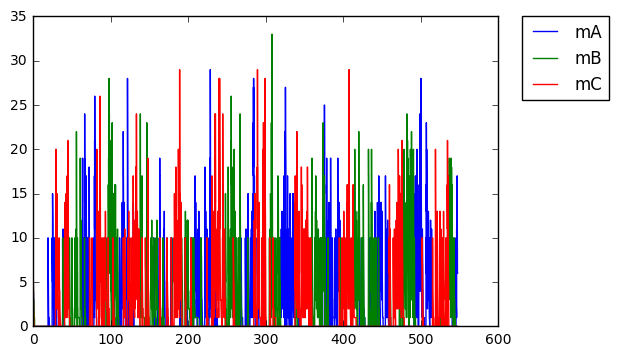

In [45]:
# N = 4 * 3 = 12
# M = 6 * 3 = 18

# A,aA,rA,mA, B,aB,rB,mB, C,aC,rC,mC
initstate = np.array([100,0,1,5, 100,0,1,5, 100,0,1,5])

inputs = np.array([
        [0,1,0,0, 0,0,0,0, 0,0,0,0], # aA -> (aA + 10 mA)
        [0,0,0,1, 0,0,0,0, 0,0,0,0], # mA -> (empty)
        [0,0,0,1, 0,0,0,0, 0,0,0,0], # mA -> (A)
        [0,1,0,0, 0,0,0,0, 1,0,0,0], # C + aA -> (rA)
        [0,0,1,0, 0,0,0,0, 0,0,0,0], # rA -> (aA)
        [1,0,0,0, 0,0,0,0, 0,0,0,0], # A -> (empty)
        
        [0,0,0,0, 0,1,0,0, 0,0,0,0],
        [0,0,0,0, 0,0,0,1, 0,0,0,0],
        [0,0,0,0, 0,0,0,1, 0,0,0,0],
        [1,0,0,0, 0,1,0,0, 0,0,0,0],
        [0,0,0,0, 0,0,1,0, 0,0,0,0],
        [0,0,0,0, 1,0,0,0, 0,0,0,0],
        
        
        [0,0,0,0, 0,0,0,0, 0,1,0,0],
        [0,0,0,0, 0,0,0,0, 0,0,0,1],
        [0,0,0,0, 0,0,0,0, 0,0,0,1],
        [0,0,0,0, 1,0,0,0, 0,1,0,0],
        [0,0,0,0, 0,0,0,0, 0,0,1,0],
        [0,0,0,0, 0,0,0,0, 1,0,0,0]
    ]);

outputs = np.array([
        [0,1,0,10, 0,0,0,0, 0,0,0,0], # (aA) -> aA + 10 mA
        [0,0,0,0,  0,0,0,0, 0,0,0,0], # (mA) -> empty
        [1,0,0,0,  0,0,0,0, 0,0,0,0], # (mA) -> A
        [0,0,1,0,  0,0,0,0, 0,0,0,0], # (C + aA) -> rA
        [0,1,0,0,  0,0,0,0, 0,0,0,0], # (rA) -> aA
        [0,0,0,0,  0,0,0,0, 0,0,0,0], # (A) -> empty      
        
        [0,0,0,0, 0,1,0,10, 0,0,0,0],
        [0,0,0,0, 0,0,0,0,  0,0,0,0],
        [0,0,0,0, 1,0,0,0,  0,0,0,0],
        [0,0,0,0, 0,0,1,0,  0,0,0,0],
        [0,0,0,0, 0,1,0,0,  0,0,0,0],
        [0,0,0,0, 0,0,0,0,  0,0,0,0],
        
        [0,0,0,0, 0,0,0,0, 0,1,0,10],
        [0,0,0,0, 0,0,0,0, 0,0,0,0 ],
        [0,0,0,0, 0,0,0,0, 1,0,0,0 ],
        [0,0,0,0, 0,0,0,0, 0,0,1,0 ],
        [0,0,0,0, 0,0,0,0, 0,1,0,0 ],
        [0,0,0,0, 0,0,0,0, 0,0,0,0 ]
    ]);

rates = np.array([1,1,1,1,1,0.1, 1,1,1,1,1,0.1, 1,1,1,1,1,0.1])

numsteps = 10000


Thist, Nhist = stochastic_simulation_algorithm(initstate, inputs, outputs, rates, numsteps)
print('     X    aX    rX    mX')
print('A: ', Nhist[-1][0:4])
print('B: ', Nhist[-1][4:8])
print('C: ', Nhist[-1][8:12])
plt.plot(Thist, [x[0] for x in Nhist], label='A')
plt.plot(Thist, [x[4] for x in Nhist], label='B')
plt.plot(Thist, [x[8] for x in Nhist], label='C')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(Thist, [x[1] for x in Nhist], label='aA')
plt.plot(Thist, [x[5] for x in Nhist], label='aB')
plt.plot(Thist, [x[9] for x in Nhist], label='aC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(Thist, [x[2] for x in Nhist], label='rA')
plt.plot(Thist, [x[6] for x in Nhist], label='rB')
plt.plot(Thist, [x[10] for x in Nhist], label='rC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(Thist, [x[3] for x in Nhist], label='mA')
plt.plot(Thist, [x[7] for x in Nhist], label='mB')
plt.plot(Thist, [x[11] for x in Nhist], label='mC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

     X    aX    rX    mX
A:  [  1.00000000e-06   1.32526405e+04   5.46988922e+04   3.80856727e+04]
B:  [  5067.53574281   9625.15031853  74202.88232464  74900.82316918]
C:  [  2.37500148e+00   1.00000000e-06   6.21195824e+04   1.11648361e+04]


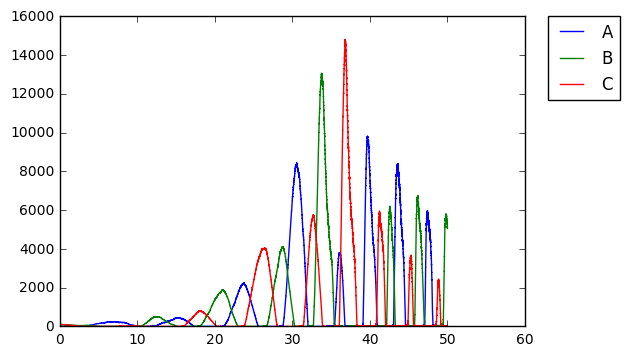

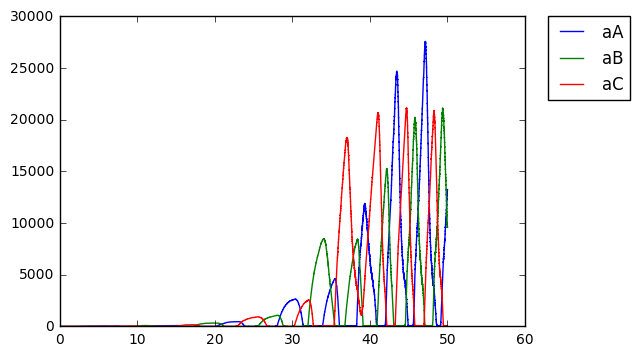

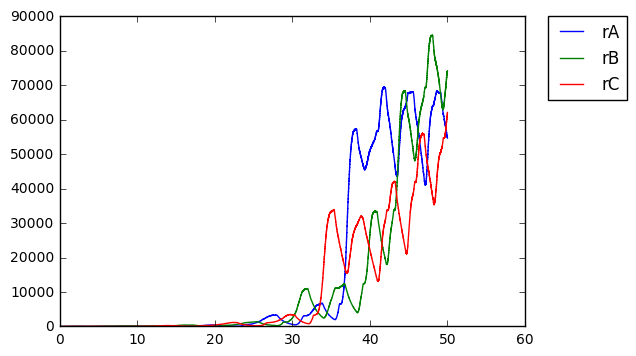

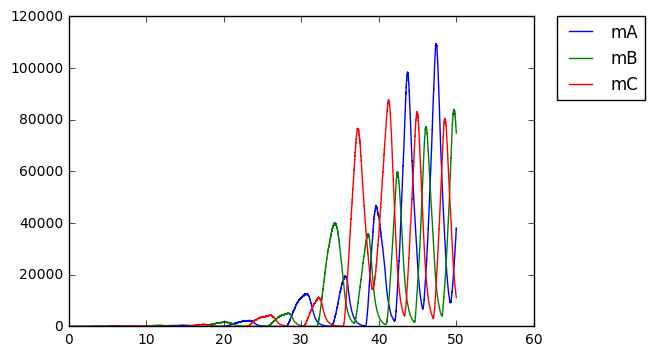

In [67]:
# N = 4 * 3 = 12
# M = 6 * 3 = 18

# A,aA,rA,mA, B,aB,rB,mB, C,aC,rC,mC
initstate = np.array([100,0,1,5, 100,0,1,5, 100,0,1,5])

inputs = np.array([
        [0,1,0,0, 0,0,0,0, 0,0,0,0], # aA -> (aA + 10 mA)
        [0,0,0,1, 0,0,0,0, 0,0,0,0], # mA -> (empty)
        [0,0,0,1, 0,0,0,0, 0,0,0,0], # mA -> (A)
        [0,1,0,0, 0,0,0,0, 1,0,0,0], # C + aA -> (rA)
        [0,0,1,0, 0,0,0,0, 0,0,0,0], # rA -> (aA)
        [1,0,0,0, 0,0,0,0, 0,0,0,0], # A -> (empty)
        
        [0,0,0,0, 0,1,0,0, 0,0,0,0],
        [0,0,0,0, 0,0,0,1, 0,0,0,0],
        [0,0,0,0, 0,0,0,1, 0,0,0,0],
        [1,0,0,0, 0,1,0,0, 0,0,0,0],
        [0,0,0,0, 0,0,1,0, 0,0,0,0],
        [0,0,0,0, 1,0,0,0, 0,0,0,0],
        
        
        [0,0,0,0, 0,0,0,0, 0,1,0,0],
        [0,0,0,0, 0,0,0,0, 0,0,0,1],
        [0,0,0,0, 0,0,0,0, 0,0,0,1],
        [0,0,0,0, 1,0,0,0, 0,1,0,0],
        [0,0,0,0, 0,0,0,0, 0,0,1,0],
        [0,0,0,0, 0,0,0,0, 1,0,0,0]
    ]);

outputs = np.array([
        [0,1,0,10, 0,0,0,0, 0,0,0,0], # (aA) -> aA + 10 mA
        [0,0,0,0,  0,0,0,0, 0,0,0,0], # (mA) -> empty
        [1,0,0,0,  0,0,0,0, 0,0,0,0], # (mA) -> A
        [0,0,1,0,  0,0,0,0, 0,0,0,0], # (C + aA) -> rA
        [0,1,0,0,  0,0,0,0, 0,0,0,0], # (rA) -> aA
        [0,0,0,0,  0,0,0,0, 0,0,0,0], # (A) -> empty      
        
        [0,0,0,0, 0,1,0,10, 0,0,0,0],
        [0,0,0,0, 0,0,0,0,  0,0,0,0],
        [0,0,0,0, 1,0,0,0,  0,0,0,0],
        [0,0,0,0, 0,0,1,0,  0,0,0,0],
        [0,0,0,0, 0,1,0,0,  0,0,0,0],
        [0,0,0,0, 0,0,0,0,  0,0,0,0],
        
        [0,0,0,0, 0,0,0,0, 0,1,0,10],
        [0,0,0,0, 0,0,0,0, 0,0,0,0 ],
        [0,0,0,0, 0,0,0,0, 1,0,0,0 ],
        [0,0,0,0, 0,0,0,0, 0,0,1,0 ],
        [0,0,0,0, 0,0,0,0, 0,1,0,0 ],
        [0,0,0,0, 0,0,0,0, 0,0,0,0 ]
    ]);

rates = np.array([1,1,1,1,1,0.1, 1,1,1,1,1,0.1, 1,1,1,1,1,0.1])

numsteps = 10000


Thist, Nhist = simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, 100000, 5/10000)
print('     X    aX    rX    mX')
print('A: ', Nhist[-1][0:4])
print('B: ', Nhist[-1][4:8])
print('C: ', Nhist[-1][8:12])
plt.plot(Thist, [x[0] for x in Nhist], label='A')
plt.plot(Thist, [x[4] for x in Nhist], label='B')
plt.plot(Thist, [x[8] for x in Nhist], label='C')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(Thist, [x[1] for x in Nhist], label='aA')
plt.plot(Thist, [x[5] for x in Nhist], label='aB')
plt.plot(Thist, [x[9] for x in Nhist], label='aC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(Thist, [x[2] for x in Nhist], label='rA')
plt.plot(Thist, [x[6] for x in Nhist], label='rB')
plt.plot(Thist, [x[10] for x in Nhist], label='rC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(Thist, [x[3] for x in Nhist], label='mA')
plt.plot(Thist, [x[7] for x in Nhist], label='mB')
plt.plot(Thist, [x[11] for x in Nhist], label='mC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

     X    aX    rX    mX
A:  [ 9.96418619  0.5719649   0.4280351   2.89019377]
B:  [ 6.6436511   0.09197835  0.90802165  0.48534234]
C:  [ 0.78115959  0.12860871  0.87139129  0.60440676]


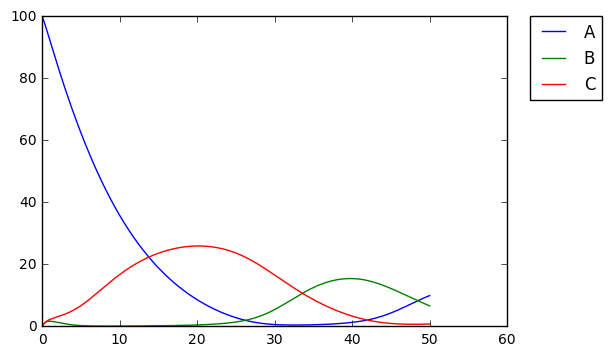

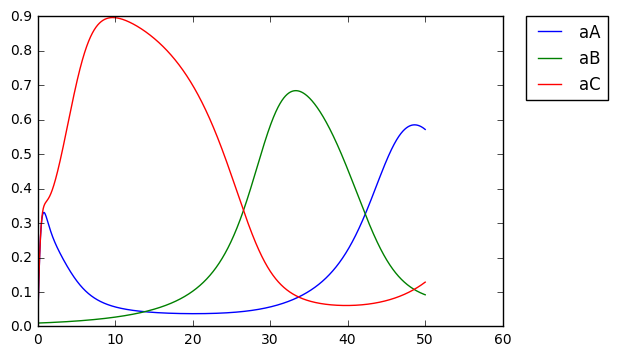

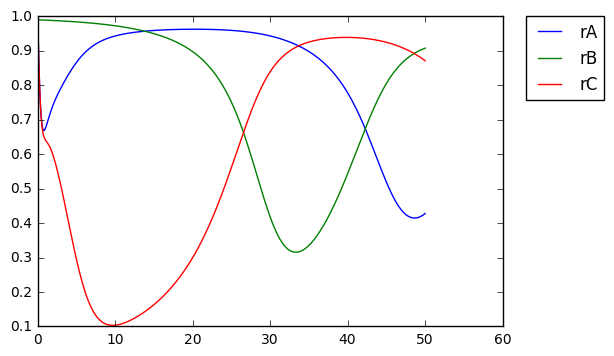

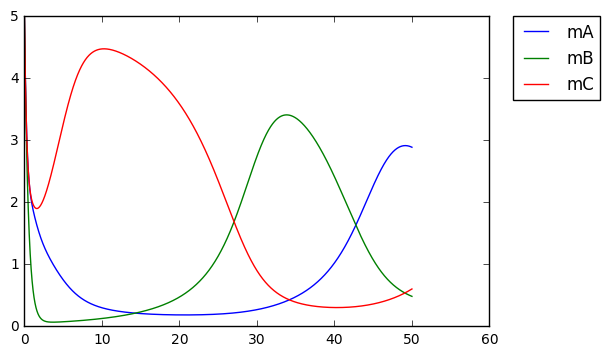

In [70]:
# N = 4 * 3 = 12
# M = 6 * 3 = 18

# A,aA,rA,mA, B,aB,rB,mB, C,aC,rC,mC
initstate = np.array([100,0,1,5, 0,0,1,5, 0,0,1,5])

inputs = np.array([
        [0,1,0,0, 0,0,0,0, 0,0,0,0], # aA -> (aA + 10 mA)
        [0,0,0,1, 0,0,0,0, 0,0,0,0], # mA -> (empty)
        [0,0,0,1, 0,0,0,0, 0,0,0,0], # mA -> (A)
        [0,1,0,0, 0,0,0,0, 1,0,0,0], # C + aA -> (rA)
        [0,0,1,0, 0,0,0,0, 0,0,0,0], # rA -> (aA)
        [1,0,0,0, 0,0,0,0, 0,0,0,0], # A -> (empty)
        
        [0,0,0,0, 0,1,0,0, 0,0,0,0],
        [0,0,0,0, 0,0,0,1, 0,0,0,0],
        [0,0,0,0, 0,0,0,1, 0,0,0,0],
        [1,0,0,0, 0,1,0,0, 0,0,0,0],
        [0,0,0,0, 0,0,1,0, 0,0,0,0],
        [0,0,0,0, 1,0,0,0, 0,0,0,0],
        
        
        [0,0,0,0, 0,0,0,0, 0,1,0,0],
        [0,0,0,0, 0,0,0,0, 0,0,0,1],
        [0,0,0,0, 0,0,0,0, 0,0,0,1],
        [0,0,0,0, 1,0,0,0, 0,1,0,0],
        [0,0,0,0, 0,0,0,0, 0,0,1,0],
        [0,0,0,0, 0,0,0,0, 1,0,0,0]
    ]);

outputs = np.array([
        [0,1,0,10, 0,0,0,0, 0,0,0,0], # (aA) -> aA + 10 mA
        [0,0,0,0,  0,0,0,0, 0,0,0,0], # (mA) -> empty
        [1,0,0,0,  0,0,0,0, 0,0,0,0], # (mA) -> A
        [0,0,1,0,  0,0,0,0, 0,0,0,0], # (C + aA) -> rA
        [0,1,0,0,  0,0,0,0, 0,0,0,0], # (rA) -> aA
        [0,0,0,0,  0,0,0,0, 0,0,0,0], # (A) -> empty      
        
        [0,0,0,0, 0,1,0,10, 0,0,0,0],
        [0,0,0,0, 0,0,0,0,  0,0,0,0],
        [0,0,0,0, 1,0,0,0,  0,0,0,0],
        [0,0,0,0, 0,0,1,0,  0,0,0,0],
        [0,0,0,0, 0,1,0,0,  0,0,0,0],
        [0,0,0,0, 0,0,0,0,  0,0,0,0],
        
        [0,0,0,0, 0,0,0,0, 0,1,0,10],
        [0,0,0,0, 0,0,0,0, 0,0,0,0 ],
        [0,0,0,0, 0,0,0,0, 1,0,0,0 ],
        [0,0,0,0, 0,0,0,0, 0,0,1,0 ],
        [0,0,0,0, 0,0,0,0, 0,1,0,0 ],
        [0,0,0,0, 0,0,0,0, 0,0,0,0 ]
    ]);

rates = np.array([1,1,1,1,1,0.1, 1,1,1,1,1,0.1, 1,1,1,1,1,0.1])

numsteps = 10000


Thist, Nhist = simulate_reaction_ode(initstate, inputs, outputs, rates, 100000, 5/10000)
print('     X    aX    rX    mX')
print('A: ', Nhist[-1][0:4])
print('B: ', Nhist[-1][4:8])
print('C: ', Nhist[-1][8:12])
plt.plot(Thist, [x[0] for x in Nhist], label='A')
plt.plot(Thist, [x[4] for x in Nhist], label='B')
plt.plot(Thist, [x[8] for x in Nhist], label='C')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(Thist, [x[1] for x in Nhist], label='aA')
plt.plot(Thist, [x[5] for x in Nhist], label='aB')
plt.plot(Thist, [x[9] for x in Nhist], label='aC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(Thist, [x[2] for x in Nhist], label='rA')
plt.plot(Thist, [x[6] for x in Nhist], label='rB')
plt.plot(Thist, [x[10] for x in Nhist], label='rC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(Thist, [x[3] for x in Nhist], label='mA')
plt.plot(Thist, [x[7] for x in Nhist], label='mB')
plt.plot(Thist, [x[11] for x in Nhist], label='mC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## General hints and warnings

* Remember that Python passes function arguments by reference. This means that if you change the argument in a function, it will also change in the caller. If you have a simulator that changes its initial state, you may inadvertedly change its value in the caller too, which may affect future calls if you are running the simulator in a loop. Directly assigning the value to a new variable is not enough because assignments are also by reference.
* The continuous-state simulators can be sensitive to the chosen $\tau$ value. If the simulation is unstable, try decreasing $\tau$.